In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample

In [ ]:
file_path =r"/content/waste_sensor_data.csv"
data = pd.read_csv(file_path)

In [ ]:
data_cleaned = data.drop(columns=['timestamp'])

label_encoder = LabelEncoder()
data_cleaned['waste_type'] = label_encoder.fit_transform(data_cleaned['waste_type'])


<ipython-input-4-c5567c9f96bf>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='waste_type', data=data_cleaned, palette='viridis')


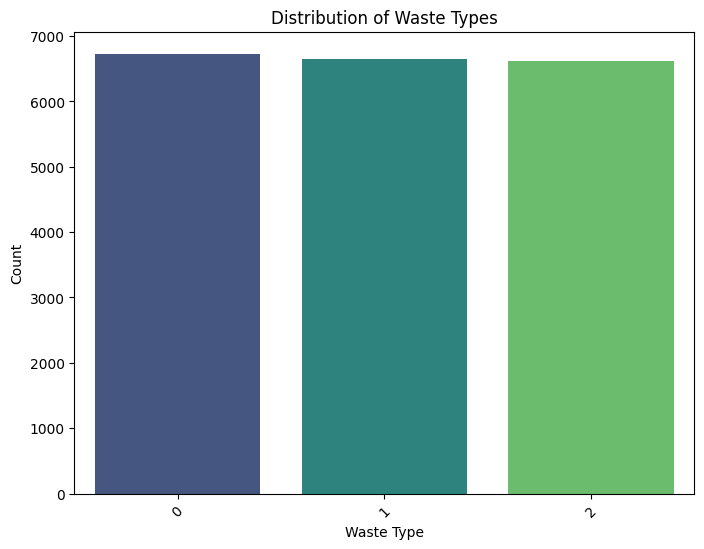

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='waste_type', data=data_cleaned, palette='viridis')
plt.title('Distribution of Waste Types')
plt.xlabel('Waste Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


Visualizing distribution of waste types...


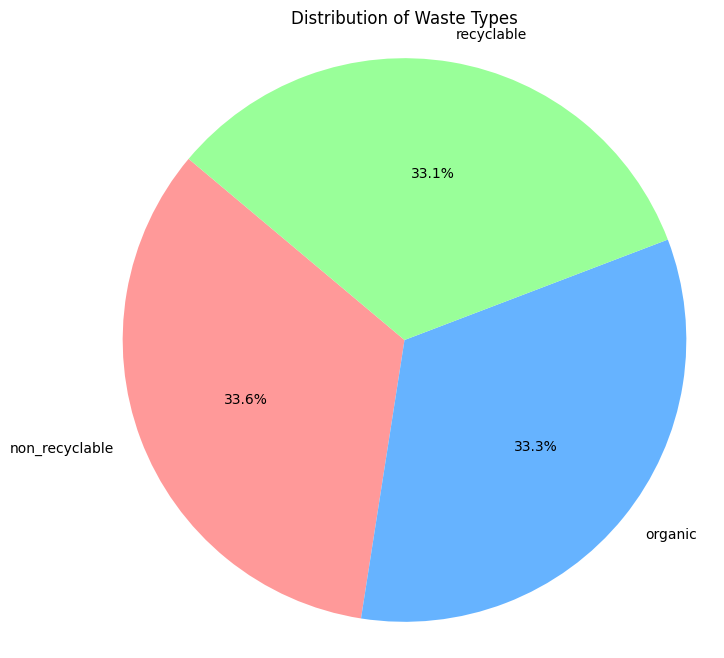

In [ ]:
print("\nVisualizing distribution of waste types...")
waste_counts = data['waste_type'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(waste_counts, labels=waste_counts.index, autopct='%1.1f%%', startangle=140,
        colors=['#ff9999', '#66b3ff', '#99ff99'])
plt.title('Distribution of Waste Types')
plt.axis('equal')
plt.show()

In [ ]:
X = data_cleaned.drop(columns=['waste_type', 'sensor_id'])
y = data_cleaned['waste_type']

In [ ]:
class_distribution = data['waste_type'].value_counts()
majority_class = data[data['waste_type'] == class_distribution.idxmax()]
balanced_data = majority_class.copy()

for waste_type, count in class_distribution.items():
    if waste_type != class_distribution.idxmax():
        minority_class = data[data['waste_type'] == waste_type]
        resampled_minority = resample(minority_class,
                                      replace=True,
                                      n_samples=class_distribution.max(),
                                      random_state=42)
        balanced_data = pd.concat([balanced_data, resampled_minority])

In [ ]:
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Feature Engineering
balanced_data['inductive_to_capacitive'] = balanced_data['inductive_property'] / (balanced_data['capacitive_property'] + 1e-9)
balanced_data['infrared_to_moisture'] = balanced_data['infrared_property'] / (balanced_data['moisture_property'] + 1e-9)

label_encoder = LabelEncoder()
balanced_data['waste_type_encoded'] = label_encoder.fit_transform(balanced_data['waste_type'])


In [ ]:
features = [
    'inductive_property', 'capacitive_property', 'moisture_property',
    'infrared_property']
X = balanced_data[features]
y = balanced_data['waste_type_encoded']

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

base_rf = RandomForestClassifier(random_state=42, n_estimators=75, max_depth=10)
boosted_rf = AdaBoostClassifier(estimator=base_rf, n_estimators=50, random_state=42)

In [ ]:
boosted_rf.fit(X_train, y_train)

AdaBoostClassifier(estimator=RandomForestClassifier(max_depth=10,
                                                    n_estimators=75,
                                                    random_state=42),
                   random_state=42)

In [ ]:

y_train_pred = boosted_rf.predict(X_train)
y_test_pred = boosted_rf.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

In [ ]:
from joblib import dump
model_filename = 'boosted_rf_model.joblib'
dump(boosted_rf, model_filename)
['boosted_rf_model.joblib']
from joblib import load
boosted_rf= load('boosted_rf_model.joblib')

In [ ]:

print(f"Boosted Random Forest Testing Accuracy: {test_accuracy:.2f}")
print("\nTesting Set Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))


Boosted Random Forest Testing Accuracy: 0.65

Testing Set Classification Report:
                precision    recall  f1-score   support

non_recyclable       0.52      0.71      0.60      1346
       organic       0.75      0.61      0.67      1346
    recyclable       0.74      0.62      0.68      1346

      accuracy                           0.65      4038
     macro avg       0.67      0.65      0.65      4038
  weighted avg       0.67      0.65      0.65      4038



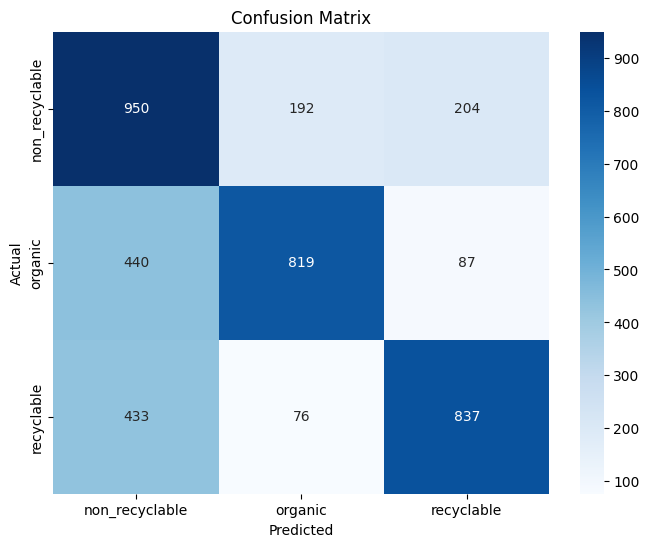

In [ ]:
conf_matrix = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()